In [1]:
from joblib import Parallel, delayed
from itertools import product
import numpy as np
import time
import os
from tqdm import tqdm
import concurrent.futures
import pickle
import gc
import matplotlib.pyplot as plt

print(f"Number of CPU cores: {os.cpu_count()}")

Number of CPU cores: 12


In [57]:
def transport(Pd_1, Pd_n1, Pd_0, diffusivity=1, dx=0.1, dt=0.1):
    return(( (( float(diffusivity) * dt)/(dx**2)) * (Pd_1 + Pd_n1 - 2*Pd_0)) + Pd_0 )

def analytical_solution(conc_boundary1, conc_boundary2, diffusivity, x, t):
    # Returns the concentration for 
    # a particular time and space
    # of a one-dimensional diffusion PDE with 
    # semi-infinite assumption
    nu = x/math.sqrt(diffusivity*t+1e-9)
    dimless_concentration = 1-math.erf(nu)
    return( dimless_concentration * (conc_boundary1 - conc_boundary2) + conc_boundary2 )

def luminal_concentration(t=0, freq=6000):
    # every 6000 seconds or 1.66 hours
    # a 'poop' will roll by and the trypsin
    # bolus will spike
    # if t < 5:
    #     content = 7.7e-1 # 7.7e-1 * 1/2*(np.cos(2*np.pi/freq * t) + 1) #umol/L
    # else:
    #     content = 0
    content = 7.7e-1# * 1/2*(np.cos(2*np.pi/freq * t) + 1) #umol/L
    return content

def conc_to_nmolecules(concentration):
    return concentration * 6.02e23 # molecules/L

def cell_diffusivity(nGoblet=1, prop_constant=1):
    return 8e-3 * nGoblet * prop_constant #um^2/s

def run_sim(sim_hours=0.5, n_goblet=1, mucus_thickness=100, mucus_diffusivity = 0.16, bolus_freq=1000, dt=0.5, n_mucus_slices=150):
    """
    sim_hours: how long to run simulation (h)
    n_goblet: value between 0-1 that represents proportion of intestine that is "goblet cell permeable" - increases cell-diffusivity
    mucus_thickness: (um)
    bolus_freq: cycle of a bolus movement (s)
    """
    nhours = sim_hours
    time_of_simulation = nhours*60*60 #s
    # dt = 0.5 # time_of_simulation/n_time_slices #s I sample at (pick something reasonable like 1 or 2)
    n_time_slices = int(time_of_simulation//dt)
    # print(n_time_slices)

    # mucus_thickness = 100 #um (10 old, 100 young)
    # mucus_diffusivity = 0.16 #um^2/s
    # stable_n_mucus_slices = mucus_thickness//(2*mucus_diffusivity*dt)
    # print(f"N slices should be over: {stable_n_mucus_slices}, but empircially 20 follows closely with semi-inf assumption better than higher resolution!")
    # n_mucus_slices = n_mucus_slices # max(int(stable_n_mucus_slices) + 1, 50)
    dx_mucus = mucus_thickness/n_mucus_slices
    mucus_transport = np.zeros([n_time_slices,n_mucus_slices])
    mucus_transport_analytical = np.zeros([n_time_slices,n_mucus_slices])
    # mucus_transport.shape

    cell_thickness = 10 #um
    # print(f"N slices should be over: {cell_thickness//(2*cell_diffusivity()*dt)}")
    n_cell_slices = 20
    n_goblet = n_goblet
    dx_cell = cell_thickness/n_cell_slices
    cell_transport = np.zeros([n_time_slices,n_cell_slices])
    # cell_transport.shape

    total_transport = np.concatenate((mucus_transport, cell_transport), axis=1 )
    # print(total_transport.shape)
    # total_transport.dtype

    for i in range((n_time_slices-1)):
        time_step = i*dt
        for j in range((total_transport.shape[1]-1)):
            if j < mucus_transport.shape[1]:
                diffusivity = mucus_diffusivity
                dx = dx_mucus
            else:
                diffusivity = cell_diffusivity(nGoblet=n_goblet)
                dx = dx_cell
            distance_step = j*dx
            if ((j-1) >= 0): #and ((j+1) < n_mucus_slices):
                total_transport[i+1,j] = transport(total_transport[i,j+1], 
                                                 total_transport[i,j-1],
                                                 total_transport[i,j],
                                                 diffusivity=diffusivity, 
                                                 dx=dx, 
                                                 dt=dt)
            else:
                total_transport[i+1,j] = luminal_concentration(time_step, freq=bolus_freq)
    return(total_transport, dx_mucus, dx_cell)

def run_one(i,j,k, nhours, dt):
    n_goblet = GobletArray[i]
    mucus_thickness = MucusArray[j]
    bolus_freq = FreqArray[k]
    
    # print(f"Testing: ngoblet-{n_goblet} muc-thic-{mucus_thickness} freq-{bolus_freq}")
    
    total_transport, dx_mucus, dx_cell = run_sim(
        sim_hours=nhours,
        mucus_thickness=mucus_thickness,
        n_goblet=n_goblet,
        bolus_freq=bolus_freq,
        dt=dt,
        n_mucus_slices=n_mucus_slices
    )
    
    return i, j, k, total_transport

## Parallel small example 1
I want to parallelize a transport simulation I created because it doesn't take terribly long to execute one run of it, but if I want 900 runs, suddenly it is taking 2 hrs! This method is a little annoying because it consumes memory and doesn't give it back. I will use another parallel small example with `import concurrent.futures`

In [2]:
GobletArray = np.arange(1,100,10) # increase the number of goblets
MucusArray = np.arange(10,100,10) # increase the thickness of mucus
FreqArray = np.arange(1200, 2400, 120) # Increase how long the bolus sits
print(GobletArray.shape, MucusArray.shape, FreqArray.shape)

(10,) (9,) (10,)


In [3]:
# Preallocate result array
param_space = np.zeros((3, len(GobletArray), len(MucusArray), len(FreqArray)))  # adjust shape to your `total_transport`
param_space.shape

(3, 10, 9, 10)

In [53]:
# Function to wrap your simulation
def run_one(i, j, k):
    n_goblet = GobletArray[i]
    mucus_thickness = MucusArray[j]
    bolus_freq = FreqArray[k]
    
    # print(f"Testing: ngoblet-{n_goblet} muc-thic-{mucus_thickness} freq-{bolus_freq}")
    time.sleep(0.1)
    total_transport = [n_goblet, mucus_thickness, bolus_freq]
    
    return i,j,k,total_transport

In [37]:
# Generate all combinations of indices
idx_combinations = list(product(range(len(GobletArray)), range(len(MucusArray)), range(len(FreqArray))))

In [38]:
# Run in parallel
results = Parallel(n_jobs=4)(delayed(run_one)(i, j, k) for i, j, k in idx_combinations)

Testing: ngoblet-51 muc-thic-90 freq-2160
Testing: ngoblet-51 muc-thic-90 freq-2280
Testing: ngoblet-61 muc-thic-10 freq-1200
Testing: ngoblet-61 muc-thic-10 freq-1320
Testing: ngoblet-61 muc-thic-10 freq-1440
Testing: ngoblet-61 muc-thic-10 freq-1560
Testing: ngoblet-61 muc-thic-10 freq-1680
Testing: ngoblet-61 muc-thic-10 freq-1800
Testing: ngoblet-61 muc-thic-10 freq-1920
Testing: ngoblet-61 muc-thic-10 freq-2040
Testing: ngoblet-61 muc-thic-10 freq-2160
Testing: ngoblet-61 muc-thic-10 freq-2280
Testing: ngoblet-61 muc-thic-20 freq-1200
Testing: ngoblet-61 muc-thic-20 freq-1320
Testing: ngoblet-61 muc-thic-20 freq-1440
Testing: ngoblet-61 muc-thic-20 freq-1560
Testing: ngoblet-61 muc-thic-20 freq-1680
Testing: ngoblet-61 muc-thic-20 freq-1800
Testing: ngoblet-61 muc-thic-20 freq-1920
Testing: ngoblet-61 muc-thic-20 freq-2040
Testing: ngoblet-61 muc-thic-20 freq-2160
Testing: ngoblet-61 muc-thic-20 freq-2280
Testing: ngoblet-61 muc-thic-30 freq-1200
Testing: ngoblet-61 muc-thic-30 fr

In [39]:
results

[(0, 0, 0, [1, 10, 1200]),
 (0, 0, 1, [1, 10, 1320]),
 (0, 0, 2, [1, 10, 1440]),
 (0, 0, 3, [1, 10, 1560]),
 (0, 0, 4, [1, 10, 1680]),
 (0, 0, 5, [1, 10, 1800]),
 (0, 0, 6, [1, 10, 1920]),
 (0, 0, 7, [1, 10, 2040]),
 (0, 0, 8, [1, 10, 2160]),
 (0, 0, 9, [1, 10, 2280]),
 (0, 1, 0, [1, 20, 1200]),
 (0, 1, 1, [1, 20, 1320]),
 (0, 1, 2, [1, 20, 1440]),
 (0, 1, 3, [1, 20, 1560]),
 (0, 1, 4, [1, 20, 1680]),
 (0, 1, 5, [1, 20, 1800]),
 (0, 1, 6, [1, 20, 1920]),
 (0, 1, 7, [1, 20, 2040]),
 (0, 1, 8, [1, 20, 2160]),
 (0, 1, 9, [1, 20, 2280]),
 (0, 2, 0, [1, 30, 1200]),
 (0, 2, 1, [1, 30, 1320]),
 (0, 2, 2, [1, 30, 1440]),
 (0, 2, 3, [1, 30, 1560]),
 (0, 2, 4, [1, 30, 1680]),
 (0, 2, 5, [1, 30, 1800]),
 (0, 2, 6, [1, 30, 1920]),
 (0, 2, 7, [1, 30, 2040]),
 (0, 2, 8, [1, 30, 2160]),
 (0, 2, 9, [1, 30, 2280]),
 (0, 3, 0, [1, 40, 1200]),
 (0, 3, 1, [1, 40, 1320]),
 (0, 3, 2, [1, 40, 1440]),
 (0, 3, 3, [1, 40, 1560]),
 (0, 3, 4, [1, 40, 1680]),
 (0, 3, 5, [1, 40, 1800]),
 (0, 3, 6, [1, 40, 1920]),
 

In [40]:
# Store results
for i, j, k, total_transport in results:
    param_space[:, i, j, k] = total_transport

### Comparing parallel to serial

In [55]:
# Parallel version
start = time.perf_counter()
results = Parallel(n_jobs=-1)(delayed(run_one)(i, j, k) for i, j, k in idx_combinations)
end = time.perf_counter()
print(f"Serial execution took {end - start:.2f} seconds")


Serial execution took 7.79 seconds


In [51]:
# Serial version
start = time.perf_counter()
results_serial = [run_one(i, j, k) for i, j, k in idx_combinations]
end = time.perf_counter()
print(f"Serial execution took {end - start:.2f} seconds")


Serial execution took 90.31 seconds


## Parallelize my simulation run

In [6]:
GobletArray = np.linspace(0.01,1,5) # increase the number of goblets
MucusArray = np.arange(10,100,10) # increase the thickness of mucus
FreqArray = np.arange(1200, 2000, 120) # Increase how long the bolus sits
print(GobletArray.shape, MucusArray.shape, FreqArray.shape)

(5,) (9,) (7,)


In [7]:
nhours = 0.5 #hr
dt = 0.15 #s

mucus_thickness = 100 #um (10 old, 100 young)
mucus_diffusivity = 0.16 #um^2/s
n_mucus_slices = 30

cell_thickness = 10 #um

n_time_slices = int(nhours*3600//dt)
print(f"Produces a {n_time_slices}x{n_mucus_slices+20} array")

Produces a 12000x50 array


In [8]:
param_space = np.zeros((n_time_slices,(n_mucus_slices+20),GobletArray.shape[0],MucusArray.shape[0], FreqArray.shape[0]))

In [9]:
param_space.shape

(12000, 50, 5, 9, 7)

In [10]:
print(f"Total size: {param_space.nbytes / 1e9:.2f} GB")  # in GB

Total size: 1.51 GB


In [11]:
start = time.perf_counter()
run_one(0, 0, 0, nhours, dt)
end = time.perf_counter()
oneRunTime = end - start

print(f"Serial execution took {end - start:.2f} seconds")
np.prod(param_space.shape[-3:])
print(f"Total serial time is: {np.prod(param_space.shape[-3:]) * oneRunTime / 60} min")
print(f"Total parallel time is: {np.prod(param_space.shape[-3:]) * oneRunTime / 8 / 60} min")

Serial execution took 0.59 seconds
Total serial time is: 3.091365448499957 min
Total parallel time is: 0.3864206810624946 min


In [12]:
# Generate all combinations of indices
idx_combinations = list(product(range(len(GobletArray)), range(len(MucusArray)), range(len(FreqArray))))

In [13]:
# # Run in parallel
# start = time.perf_counter()
# with Parallel(n_jobs=8) as parallel:
#     for i, j, k, total_transport in parallel(delayed(run_one)(i, j, k, nhours, dt) for i, j, k in idx_combinations):
#         param_space[:, :, i, j, k] = total_transport  # Write directly
# end = time.perf_counter()

# print(f"Parallel execution took {(end - start)/60:.2f} min")
# del parallel
# gc.collect()

In [14]:
# # Save to a file using pickle
# with open("param_space_2.pkl", "wb") as f:
#     pickle.dump(param_space, f)

In [18]:
with open("param_space_2.pkl", "rb") as f:
    param_space = pickle.load(f)

In [19]:
i = 0
j = 0
k = 0

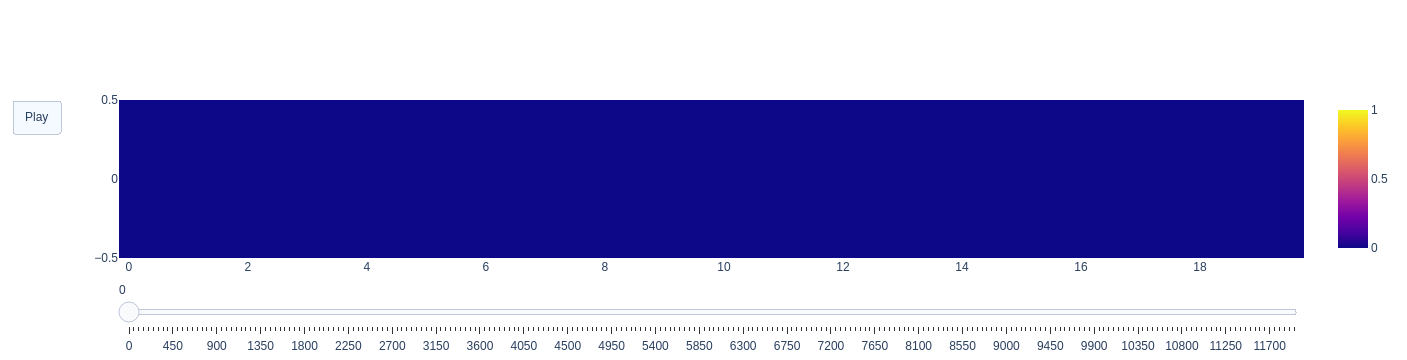

In [20]:
total_transport = param_space[:,:,i,j,k]
dx_mucus = MucusArray[j]/n_mucus_slices
n_cell_slices = 20
dx_cell = 10/n_cell_slices

import plotly.io as pio
pio.renderers.default = 'plotly_mimetype'  # or 'notebook_connected'
import plotly.graph_objs as go
import numpy as np

data = total_transport
n_time_slices, n_spatial_points = data.shape

# Scale factor for x-axis
scale_um_per_point = dx_mucus  # e.g., 5 µm per spatial point
x_coords = np.concatenate((np.arange(n_mucus_slices) * dx_mucus, n_mucus_slices* dx_mucus+np.arange(n_cell_slices) * dx_cell))  # now in hr
# np.arange(n_spatial_points) * scale_um_per_point  # now in µm

# Downsample to avoid huge file
indices = np.arange(0, n_time_slices, 50)  # e.g., every 50 frames
frames = [
    go.Frame(data=[go.Heatmap(z=[data[i]], x=x_coords, zmin=0, zmax=1)], name=str(i))
    for i in indices
]

fig = go.Figure(
    data=[go.Heatmap(z=[data[0]], x= x_coords, zmin=0, zmax=1)],
    frames=frames,
    layout=go.Layout(
        updatemenus=[{
            "type": "buttons",
            "buttons": [{"label": "Play", "method": "animate", "args": [None]}]
        }],
        sliders=[{
            "steps": [{"args": [[str(i)], {"frame": {"duration": 0, "redraw": True}}],
                       "label": str(i), "method": "animate"} for i in indices],
            "active": 0
        }]
    )
)
fig.show()

## Analyze how the final mucus layer changes with params
1. Plot final layer as f(t)
2. Compute avg of final layer index -10 for each time point
3. See how this average changes with dGoblet, dMuc, dFreq

### Ploting the final layers in time

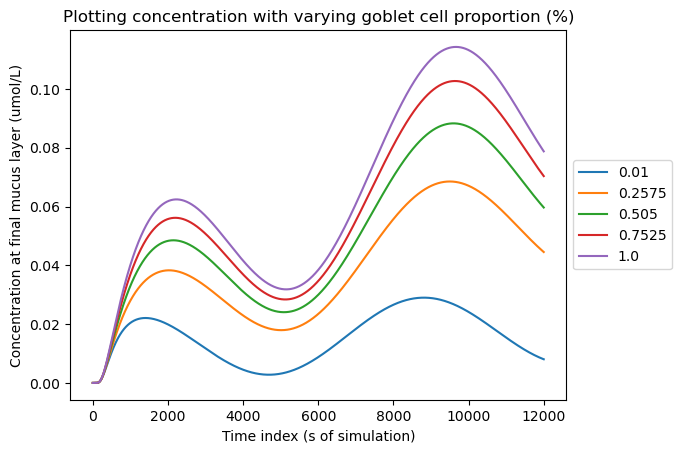

In [21]:
for i in range(0,5):
    avg_df = param_space[:,-21,i,0,0]
    plt.plot(avg_df, label=GobletArray[i])
plt.xlabel("Time index (s of simulation)")  # Optional: label for x-axis
plt.ylabel("Concentration at final mucus layer (umol/L)")       # Optional: label for y-axis
plt.title("Plotting concentration with varying goblet cell proportion (%)")  # Optional: plot title
plt.legend()  # Show legend
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

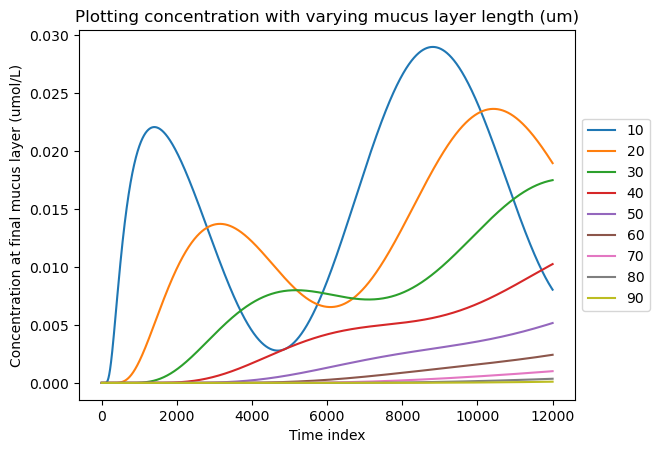

In [22]:
for i in range(0,9):
    avg_df = param_space[:,-21,0,i,0]
    plt.plot(avg_df, label=MucusArray[i])
plt.xlabel("Time index")  # Optional: label for x-axis
plt.ylabel("Concentration at final mucus layer (umol/L)")       # Optional: label for y-axis
plt.title("Plotting concentration with varying mucus layer length (um)")  # Optional: plot title
plt.legend()  # Show legend
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

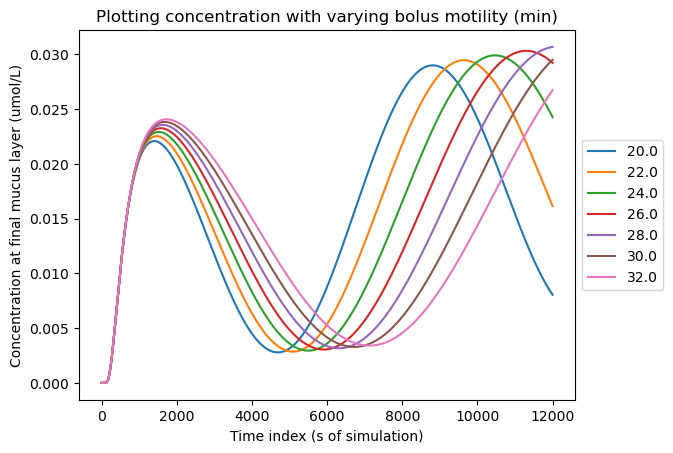

In [23]:
for i in range(0,7):
    avg_df = param_space[:,-21,0,0,i]
    plt.plot(avg_df, label=FreqArray[i]/60)
plt.xlabel("Time index (s of simulation)")  # Optional: label for x-axis
plt.ylabel("Concentration at final mucus layer (umol/L)")       # Optional: label for y-axis
plt.title("Plotting concentration with varying bolus motility (min)")  # Optional: plot title
plt.legend()  # Show legend
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### Computing the average with time and gradients

In [24]:
avg_df = param_space[:,-21,0,0,0]
print(np.mean(avg_df))

0.015546834701831618


In [25]:
avg_array = np.mean(param_space[:, -21, :, :, :], axis=0, keepdims=True)
avg_array = np.squeeze(avg_array, axis=0)  # remove the first (axis 0) dimension

In [26]:
avg_array.shape

(5, 9, 7)

In [27]:
avg_array[0,0,0]

0.015546834701831592

In [28]:
gradients = np.gradient(avg_array)  # Returns a list of arrays: one for each axis

In [29]:
# First gradient has how the concentration at the final mucus layer changes with changing cell permeability

In [30]:
gradients[0].shape

(5, 9, 7)

### Plotting f(t,x) vs df(t,x)/dx

#### Concentration changing with goblet cells

In [122]:
i=0
j=0
k=0

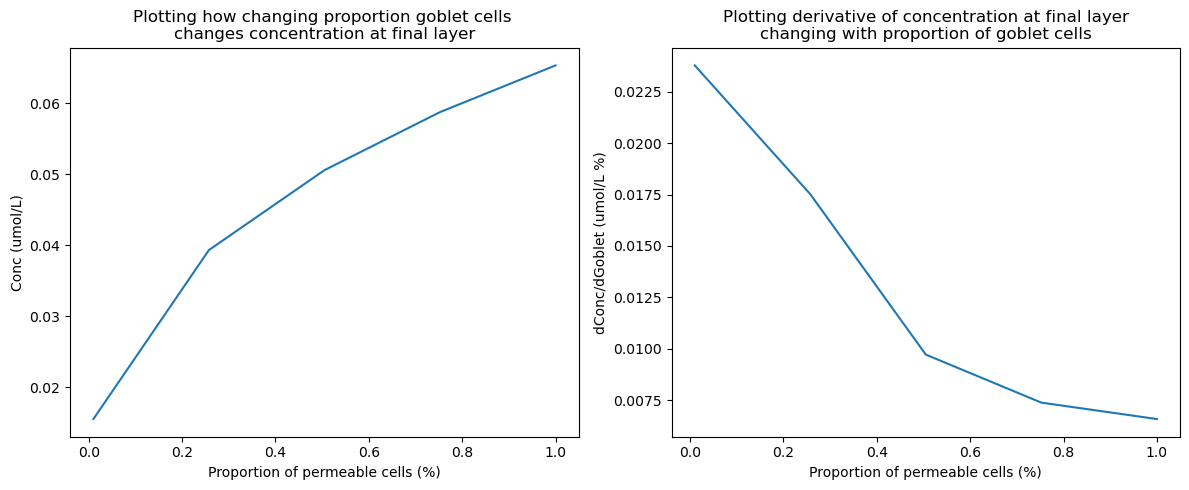

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

f_t = avg_array[:,j,k]
df_tdgoblet = gradients[0][:,j,k]

axes[0].plot(GobletArray, f_t)
axes[0].set_xlabel("Proportion of permeable cells (%)")  # Optional: label for x-axis
axes[0].set_ylabel("Conc (umol/L)")       # Optional: label for y-axis
axes[0].set_title("Plotting how changing proportion goblet cells \nchanges concentration at final layer")  # Optional: plot title

axes[1].plot(GobletArray, df_tdgoblet)
axes[1].set_xlabel("Proportion of permeable cells (%)")  # Optional: label for x-axis
axes[1].set_ylabel("dConc/dGoblet (umol/L %)")       # Optional: label for y-axis
axes[1].set_title("Plotting derivative of concentration at final layer\nchanging with proportion of goblet cells")  # Optional: plot title

plt.tight_layout()
plt.show()

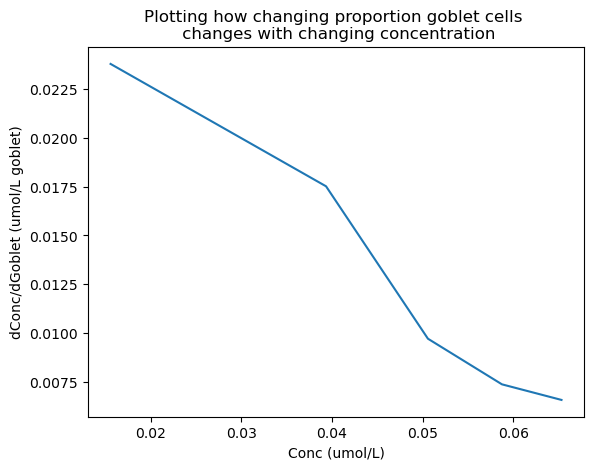

In [125]:
f_t = avg_array[:,j,k]
df_tdgoblet = gradients[0][:,j,k]
plt.plot(f_t,df_tdgoblet)

plt.xlabel("Conc (umol/L)")  # Optional: label for x-axis
plt.ylabel("dConc/dGoblet (umol/L goblet)")       # Optional: label for y-axis
plt.title("Plotting how changing proportion goblet cells \n changes with changing concentration")  # Optional: plot title
plt.show()

It seems that as we increase the amount of permeable cells, we will eventually reach a steady-state average amount of signaling molecule at the brush border of the epithelial cells. But if the permeability is already low, then even small changes to permeability significantly impact how much protein reaches the cell-membrane and potentially act as signaling molecules.

#### Concentration changing with mucus layer thickness

In [148]:
i=0
j=0
k=5

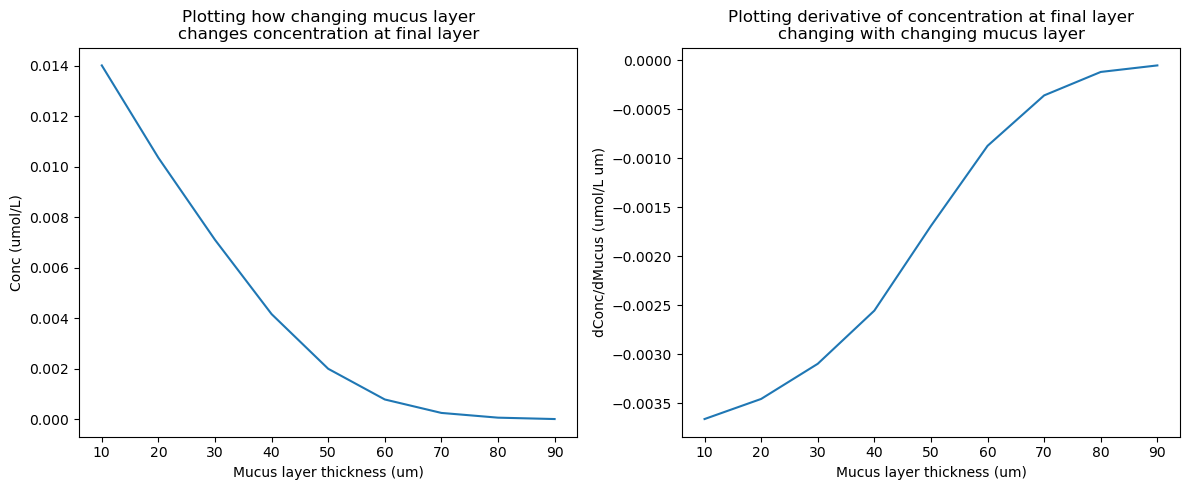

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

f_t = avg_array[i,:,k]
df_tdgoblet = gradients[1][i,:,k]

axes[0].plot(MucusArray, f_t)
axes[0].set_xlabel("Mucus layer thickness (um)")  # Optional: label for x-axis
axes[0].set_ylabel("Conc (umol/L)")       # Optional: label for y-axis
axes[0].set_title("Plotting how changing mucus layer\nchanges concentration at final layer")  # Optional: plot title

axes[1].plot(MucusArray, df_tdgoblet)
axes[1].set_xlabel("Mucus layer thickness (um)")  # Optional: label for x-axis
axes[1].set_ylabel("dConc/dMucus (umol/L um)")       # Optional: label for y-axis
axes[1].set_title("Plotting derivative of concentration at final layer\nchanging with changing mucus layer")  # Optional: plot title

plt.tight_layout()
plt.show()

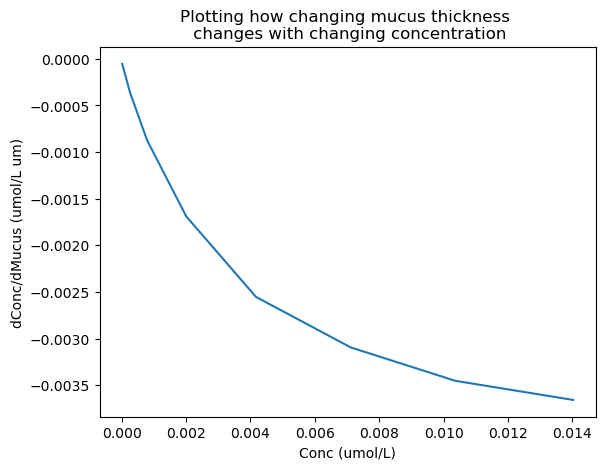

In [150]:
plt.plot(f_t,df_tdgoblet)

plt.xlabel("Conc (umol/L)")  # Optional: label for x-axis
plt.ylabel("dConc/dMucus (umol/L um)")       # Optional: label for y-axis
plt.title("Plotting how changing mucus thickness \n changes with changing concentration")  # Optional: plot title
plt.show()

When the concentration is low, the rate of change due to changing mucus is very low. But as concentration increases, suddenly having more mucus significantly decreases the concentration at the cell membrane (pretty intuitive result). This seems very frequency and bolus motility dependent.

#### Concentration changing with bolus motility

In [156]:
i=0
j=0
k=0

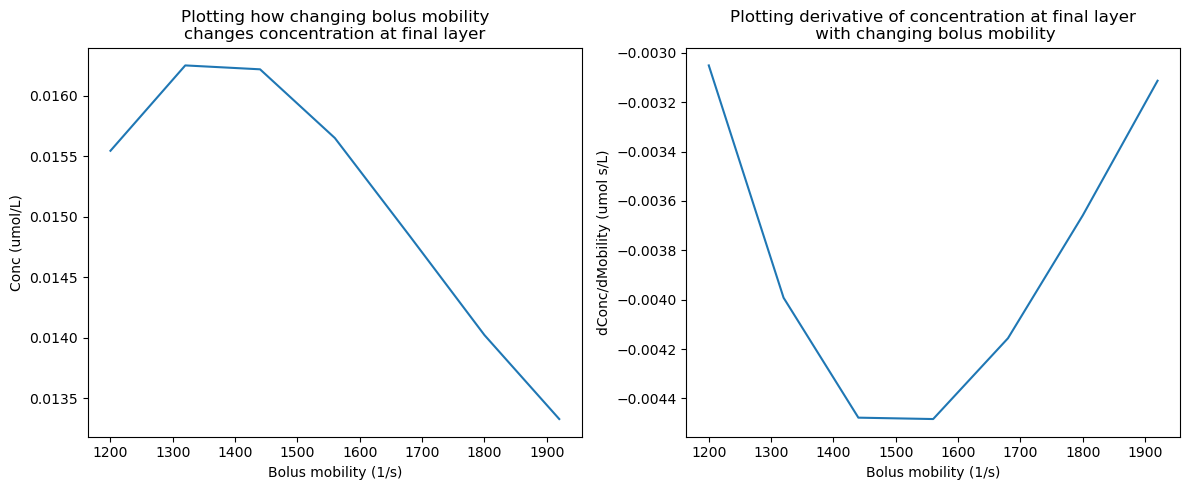

In [159]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

f_t = avg_array[i,j,:]
df_tdgoblet = gradients[1][i,j,:]

axes[0].plot(FreqArray, f_t)
axes[0].set_xlabel("Bolus mobility (1/s)")  # Optional: label for x-axis
axes[0].set_ylabel("Conc (umol/L)")       # Optional: label for y-axis
axes[0].set_title("Plotting how changing bolus mobility\nchanges concentration at final layer")  # Optional: plot title

axes[1].plot(FreqArray, df_tdgoblet)
axes[1].set_xlabel("Bolus mobility (1/s)")  # Optional: label for x-axis
axes[1].set_ylabel("dConc/dMobility (umol s/L)")       # Optional: label for y-axis
axes[1].set_title("Plotting derivative of concentration at final layer\n with changing bolus mobility")  # Optional: plot title

plt.tight_layout()
plt.show()

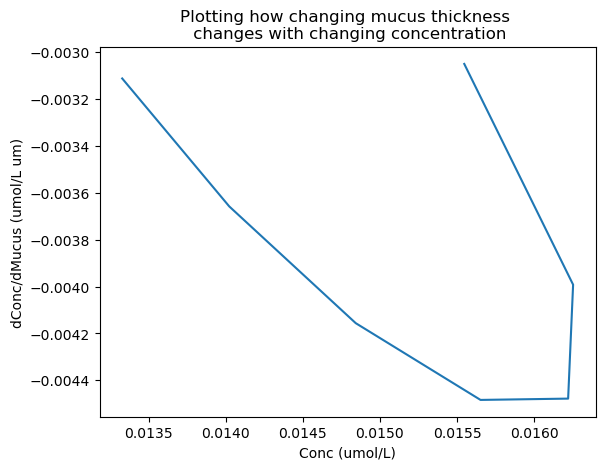

In [158]:
plt.plot(f_t,df_tdgoblet)

plt.xlabel("Conc (umol/L)")  # Optional: label for x-axis
plt.ylabel("dConc/dMucus (umol/L um)")       # Optional: label for y-axis
plt.title("Plotting how changing mucus thickness \n changes with changing concentration")  # Optional: plot title
plt.show()

Incredibly mucus layer thickness dependent results! Low mucus layer produces LESS concentration if mobility was slow! But with more mucus, we get linear relationship with slower bolus producing more concentration.

## Next steps

Next step would be to convert the [5x9x7] array into a 315x4 array. Rows are a cell layer under different conditions. Columns are 1=Concentration, 2=Goblet cell prop, 3=Mucus thickness, 4=Frequency. Now that would be quite usable!

### Saving the final layer time series

In [34]:
print(f"Total size: {param_space[:,-21,:,:,:].nbytes / 1e6:.2f} MB")  # in GB

Total size: 30.24 MB


In [35]:
# # Save to a file using pickle
# with open("param_space_final_layer.pkl", "wb") as f:
#     pickle.dump(param_space[:,-21,:,:,:], f)

In [37]:
with open("param_space_final_layer.pkl", "rb") as f:
    final_layer = pickle.load(f)
print(final_layer.shape)

In [50]:
grad_goblet, grad_mucus, grad_freq = np.gradient(
    final_layer,
    GobletArray,  # shape: (10,)
    MucusArray,   # shape: (9,)
    FreqArray,    # shape: (10,)
    axis=(1, 2, 3)
)

In [58]:
grad_goblet.shape

(12000, 5, 9, 7)

In [ ]:
sensitivity_matrix = np.array([gradient_final_layer[0][] ])

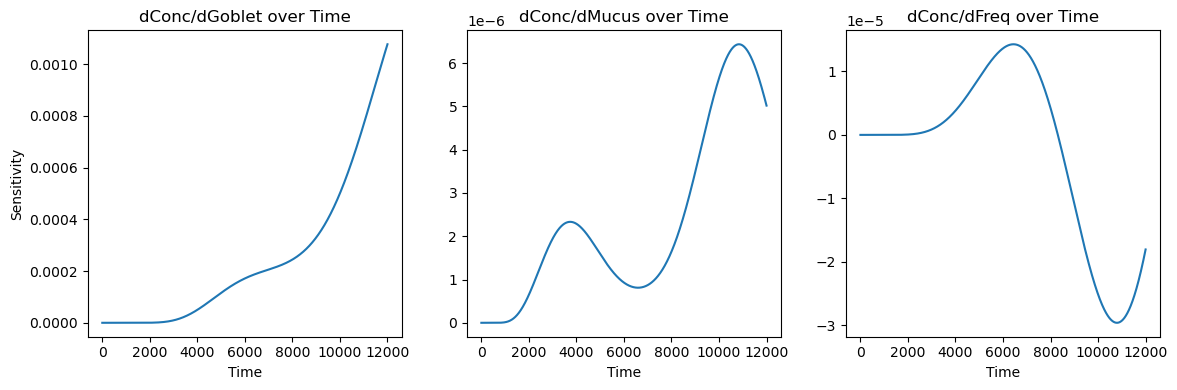

In [56]:
g = 2  # goblet index
m = 2  # mucus index
f = 0  # freq index


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(grad_goblet[:, g, m, f]**2)
plt.title("dConc/dGoblet over Time")
plt.xlabel("Time")
plt.ylabel("Sensitivity")

plt.subplot(1, 3, 2)
plt.plot(grad_mucus[:, g, m, f]**2)
plt.title("dConc/dMucus over Time")
plt.xlabel("Time")

plt.subplot(1, 3, 3)
plt.plot(grad_freq[:, g, m, f])
plt.title("dConc/dFreq over Time")
plt.xlabel("Time")

plt.tight_layout()
plt.show()
